In [1]:
import tensorflow as tf
from tensorflow import keras

import os
from os import path

import tempfile
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
pd.options.mode.chained_assignment = None

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1ti23vw_ because the default path (/home/juliuswa/installed/apache-tomcat-9.0.30/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
df_name = "95"

data_path = "../../RoboDocData"
df_path = f"{data_path}/{df_name}"

df = pd.read_pickle(f"{df_path}/dataframe_{df_name}.pkl")

In [3]:
df.columns

Index([                    'age',                  'gender',
                        'weight',                  'height',
                'heartrate_mean',           'heartrate_min',
                 'heartrate_max',             'meanbp_mean',
                    'meanbp_min',              'meanbp_max',
       ...
                            1432,                      1433,
                            1434,                      1435,
                            1436,                      1437,
       'length_of_stay_hospital',      'length_of_stay_icu',
                 'days_to_death',        'died_in_hospital'],
      dtype='object', length=1507)

In [4]:
length_of_stay_hospital = df.pop("length_of_stay_hospital")
length_of_stay_icu = df.pop("length_of_stay_icu")
days_to_death = df.pop("days_to_death")
died_in_hospital = df.pop("died_in_hospital")

## Give non diseases more weight:

In [5]:
def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

In [6]:
for c in df.columns:
    if not RepresentsInt(c):
        df[c] = df[c] * 2
        
df.describe()

,age,gender,weight,height,heartrate_mean,heartrate_min,heartrate_max,meanbp_mean,meanbp_min,meanbp_max,...,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437
count,49249.000000,49249.000000,49249.000000,49249.000000,49249.000000,49249.000000,49249.000000,49249.000000,49249.000000,49249.000000,...,49249.000000,49249.000000,49249.000000,49249.000000,49249.000000,49249.000000,49249.000000,49249.000000,49249.000000,49249.000000
mean,1.301317,1.124165,0.532762,0.332825,0.824582,1.003702,0.586398,0.891182,0.935742,0.592706,...,0.460396,0.414438,0.441432,0.467118,0.468005,0.390359,0.382845,0.483282,0.414749,0.480476
std,0.456289,0.992272,0.144817,0.046561,0.232255,0.212930,0.164946,0.164758,0.218024,0.187507,...,0.040815,0.047178,0.043721,0.032639,0.038203,0.032610,0.043993,0.041204,0.036523,0.034278
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.441472,0.332825,0.656716,0.862424,0.472000,0.773723,0.816000,0.485507,...,0.451100,0.405372,0.431374,0.459885,0.460782,0.384053,0.373342,0.475068,0.406914,0.473426
50%,1.342105,2.000000,0.532762,0.332825,0.805970,0.990402,0.568000,0.875912,0.935742,0.557971,...,0.459496,0.414659,0.440412,0.466340,0.468213,0.390486,0.382529,0.483240,0.414160,0.480041
75%,1.657895,2.000000,0.588629,0.332825,0.970149,1.132599,0.688000,0.992701,1.056000,0.652174,...,0.466922,0.424079,0.448902,0.472839,0.475337,0.396407,0.390972,0.491892,0.421383,0.486670
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Cluster:

In [19]:
from sklearn.cluster import KMeans, DBSCAN

In [51]:
t_start = time.time()
clustering = KMeans(n_clusters=2).fit(df.values)
t_end = time.time()

cluster_labels = clustering.labels_

print(f"Time elapsed: {(t_end - t_start) / 60:.2f} minutes")
print(cluster_labels[0:20])

Time elapsed: 0.26 minutes
[0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0]


## Reduce dimensionality to 3:

In [52]:
from sklearn.decomposition import PCA
import pickle as pk

In [53]:
pca = PCA(n_components=3)

t_start = time.time()
M = pca.fit_transform(df.values)
t_end = time.time()

with open(f"{df_path}/three_dim_admissions_{df_name}.npy", 'wb') as f:
    np.save(f, M)

print(f"Time elapsed: {(t_end - t_start) / 60:.2f} minutes")
print(M.shape)

Time elapsed: 0.15 minutes
(49249, 3)


## Add lables:

In [54]:
df_3dim = pd.DataFrame(M)
df_3dim["died_in_hospital"] = died_in_hospital
df_3dim["cluster"] = cluster_labels

df_3dim.describe()

,0,1,2,cluster
count,4.924900e+04,4.924900e+04,4.924900e+04,49249.000000
mean,-1.184502e-16,3.438718e-17,-2.306606e-16,0.331113
std,1.401173e+00,9.968918e-01,6.942496e-01,0.470619
min,-1.451319e+00,-1.087914e+00,-1.527776e+00,0.000000
25%,-1.270127e+00,-9.112655e-01,-3.291181e-01,0.000000
50%,-5.629164e-01,-7.342494e-01,9.893217e-02,0.000000
75%,1.238865e+00,1.087244e+00,4.353292e-01,1.000000
max,2.779514e+00,1.423020e+00,2.736549e+00,1.000000


## Visualize died_in_hospital:

In [55]:
pos_df = df_3dim[df_3dim.died_in_hospital  == 1][::5]
neg_df = df_3dim[df_3dim.died_in_hospital  == 0][::38]

print(len(pos_df))
print(len(neg_df))

1134
1147


<IPython.core.display.Javascript object>


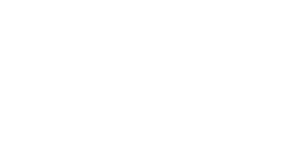

In [56]:
%matplotlib notebook

sns.set(style = "darkgrid")

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlabel("0")
ax.set_ylabel("1")
ax.set_zlabel("2")

ax.scatter(pos_df[0], pos_df[1], pos_df[2], alpha=0.2, color="r", marker=".")
ax.scatter(neg_df[0], neg_df[1], neg_df[2], alpha=0.2, color="b", marker=".")


plt.show()

## Visualize clusters:

<IPython.core.display.Javascript object>


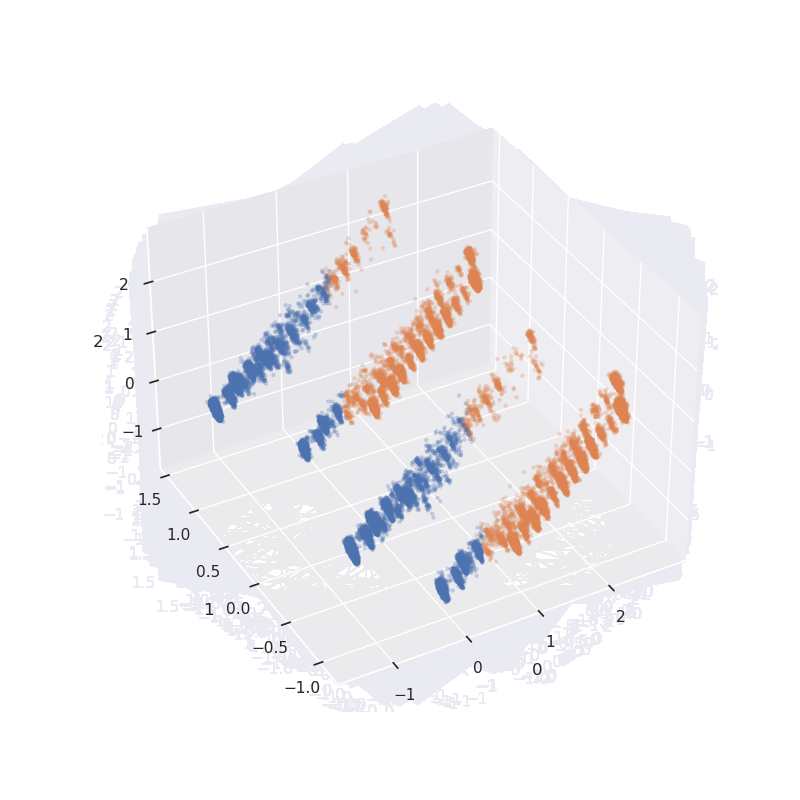

cluster 0: 32942
cluster 1: 16307
cluster 2: 0
cluster 3: 0
cluster 4: 0
cluster 5: 0


In [57]:
%matplotlib notebook

sns.set(style = "darkgrid")

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlabel("0")
ax.set_ylabel("1")
ax.set_zlabel("2")

for i in range(6):
    df_3dim_cluster = df_3dim[df_3dim.cluster == i]
    print(f"cluster {i}: {len(df_3dim_cluster)}")
    ax.scatter(df_3dim_cluster[0], df_3dim_cluster[1], df_3dim_cluster[2], alpha=0.2, marker=".")

plt.show()